<a href="https://colab.research.google.com/github/TDStriker/Projects-in-ML/blob/main/ML_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset
import time
from torchvision import transforms

Data

In [2]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/jack of spades/059.jpg  
  inflating: train/jack of spades/060.jpg  
  inflating: train/jack of spades/061.jpg  
  inflating: train/jack of spades/062.jpg  
  inflating: train/jack of spades/063.jpg  
  inflating: train/jack of spades/064.jpg  
  inflating: train/jack of spades/065.jpg  
  inflating: train/jack of spades/066.jpg  
  inflating: train/jack of spades/067.jpg  
  inflating: train/jack of spades/068.jpg  
  inflating: train/jack of spades/069.jpg  
  inflating: train/jack of spades/070.jpg  
  inflating: train/jack of spades/071.jpg  
  inflating: train/jack of spades/072.jpg  
  inflating: train/jack of spades/073.jpg  
  inflating: train/jack of spades/074.jpg  
  inflating: train/jack of spades/075.jpg  
  inflating: train/jack of spades/076.jpg  
  inflating: train/jack of spades/077.jpg  
  inflating: train/jack of spades/078.jpg  
  inflating: train/jack of spades/079.jpg  
  inflating: train/jack o

In [2]:
csv = pd.read_csv('cards.csv')

In [4]:
print(csv)

      class index                   filepaths         labels card type  \
0               0  train/ace of clubs/001.jpg   ace of clubs       ace   
1               0  train/ace of clubs/002.jpg   ace of clubs       ace   
2               0  train/ace of clubs/003.jpg   ace of clubs       ace   
3               0  train/ace of clubs/004.jpg   ace of clubs       ace   
4               0  train/ace of clubs/005.jpg   ace of clubs       ace   
...           ...                         ...            ...       ...   
8150           52   valid/two of spades/1.jpg  two of spades       two   
8151           52   valid/two of spades/2.jpg  two of spades       two   
8152           52   valid/two of spades/3.jpg  two of spades       two   
8153           52   valid/two of spades/4.jpg  two of spades       two   
8154           52   valid/two of spades/5.jpg  two of spades       two   

     data set  
0       train  
1       train  
2       train  
3       train  
4       train  
...       ...  

In [3]:
#Convert the card names to numbers for the model to process
le = LabelEncoder()
csv['labels'] = le.fit_transform(csv['labels'])

In [4]:
csv=csv.drop(csv.index[120]) #It appears this value should not be here. File does not exist and the path is not names properly

In [5]:
csv = csv.drop(columns=["class index","card type"])

In [6]:
train = csv[csv['data set'] == "train"].drop(columns=["data set"])
test = csv[csv['data set'] == "test"].drop(columns=["data set"])
valid = csv[csv['data set'] == "valid"].drop(columns=["data set"])

Task 1

CNN

For the CNN architecture I decided to use 2 Convolutional Layers and no pooling layers. I used the 2 convolution layers to try to provide more ability for it to recognize the shapes without adding too much extra computation from having too many layers.

In [7]:
#Hyperparameters
learning_rate=1e-3
layer_size=50
num_hidden_layers=2
batch_size = 64
epochs = 7

in_dim = (224,224,3)
out_dim=53

In [8]:
class CNNetwork(nn.Module):
  def __init__(self,in_dim,out_dim,layer_size,num_hidden_layers=1):
        super().__init__()
        self.in_dim = in_dim
        self.num_hidden_layers = num_hidden_layers
        self.num_layers = num_hidden_layers*2+1
        self.layer_size = layer_size

        self.l1_filters = 20
        self.l1_kernel = 4
        self.l1_stride = 1

        self.l2_filters = 20
        self.l2_kernel = 4
        self.l2_stride = 1

        self.l1_h = (self.in_dim[0]-self.l1_kernel)/self.l1_stride + 1
        self.l1_w = (self.in_dim[1]-self.l1_kernel)/self.l1_stride + 1

        self.l2_h = (self.l1_h-self.l2_kernel)/self.l2_stride + 1
        self.l2_w = (self.l1_w-self.l2_kernel)/self.l2_stride + 1

        self.fc_in = int(self.l2_filters*self.l2_h*self.l2_w)

        self.conv1 = nn.Conv2d(3, self.l1_filters, self.l1_kernel, stride=self.l1_stride)
        self.conv2 = nn.Conv2d(self.l1_filters, self.l2_filters, self.l2_kernel, stride=self.l2_stride)
        #self.pool = nn.MaxPool2d(2, 2)

        self.lin = nn.Linear(self.fc_in, out_dim)

  def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        #x=self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)


        x = torch.flatten(x, 1)

        x=self.lin(x)
        #Active

        return x

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model = CNNetwork(in_dim,out_dim,layer_size,num_hidden_layers)

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [9]:
trainset = datasets.ImageFolder(root='train', transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.ImageFolder(root='test', transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
validset = datasets.ImageFolder(root='valid', transform=transforms.ToTensor())
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)

In [13]:
def train_loop(loader, model, loss_fn, optimizer,size):
    model.train()
    for batch, (data, target) in enumerate(loader):
        # Compute prediction and loss
        pred = model(data)
        loss = loss_fn(pred, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

'''
def test_loop(loader, model, loss_fn):
    model.eval()

    num_batches = int((len(loader)/batch_size)+.999)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data, target in loader:
            pred = model(data)
            test_loss += loss_fn(pred, target).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")
'''

def test_loop(loader, model, loss_fn):
    model.eval()

    test_loss, correct, total = 0,0,0

    with torch.no_grad():
        for data, target in loader:
            out = model(data)
            test_loss += loss_fn(out, target).item()

            pred = out.data.max(1, keepdim=True)[1]
            correct += (pred.eq(target.data.view_as(pred)).sum().item())

            total = total + 1

    print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(loader.dataset),
        (100. * correct / len(loader.dataset))), flush=True)

    return 100.0 * correct / len(loader.dataset)

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer,len(train))
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.972028  [   64/ 7624]
loss: 3.986080  [  704/ 7624]
loss: 4.005997  [ 1344/ 7624]
loss: 3.961142  [ 1984/ 7624]
loss: 3.955696  [ 2624/ 7624]
loss: 3.952403  [ 3264/ 7624]
loss: 3.930475  [ 3904/ 7624]
loss: 3.949175  [ 4544/ 7624]
loss: 3.938323  [ 5184/ 7624]
loss: 3.908879  [ 5824/ 7624]
loss: 3.881196  [ 6464/ 7624]
loss: 3.881958  [ 7104/ 7624]
Test set: Avg. loss: 19.2117, Accuracy: 19/265 (7.17%)
Epoch 2
-------------------------------
loss: 3.874621  [   64/ 7624]
loss: 3.809116  [  704/ 7624]
loss: 3.769536  [ 1344/ 7624]
loss: 3.722438  [ 1984/ 7624]
loss: 3.828696  [ 2624/ 7624]
loss: 3.776762  [ 3264/ 7624]
loss: 3.689412  [ 3904/ 7624]
loss: 3.578656  [ 4544/ 7624]
loss: 3.724838  [ 5184/ 7624]
loss: 3.550451  [ 5824/ 7624]
loss: 3.568602  [ 6464/ 7624]
loss: 3.488202  [ 7104/ 7624]
Test set: Avg. loss: 17.4179, Accuracy: 29/265 (10.94%)
Epoch 3
-------------------------------
loss: 3.482333  [   64/ 7624]
loss: 3.272615  [  

In [ ]:
test_loop(test_loader, model, loss_fn)

Test set: Avg. loss: 13.9201, Accuracy: 80/265 (30.19%)


30.18867924528302

The evaluationmetric used is final test accuracy. The model achieved 30% accuracy, which while low is still significantly better than random guessing. Many of the card images are from unique card decks which could throw off accuracy and without a more intricate architecture it would likely be difficult to differentiate between a club/spade or heart/diamond.

Transfer Learning

In [ ]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, out_dim)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


In [ ]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer,len(train))
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.590266  [   64/ 7624]
loss: 1.856168  [  704/ 7624]
loss: 1.828470  [ 1344/ 7624]
loss: 1.892631  [ 1984/ 7624]
loss: 1.916631  [ 2624/ 7624]
loss: 1.824441  [ 3264/ 7624]
loss: 2.497229  [ 3904/ 7624]
loss: 1.682967  [ 4544/ 7624]
loss: 1.891596  [ 5184/ 7624]
loss: 1.867953  [ 5824/ 7624]
loss: 1.924228  [ 6464/ 7624]
loss: 1.581586  [ 7104/ 7624]
Test set: Avg. loss: 14.9296, Accuracy: 73/265 (27.55%)
Epoch 2
-------------------------------
loss: 2.927191  [   64/ 7624]
loss: 1.794971  [  704/ 7624]
loss: 2.143730  [ 1344/ 7624]
loss: 2.281467  [ 1984/ 7624]
loss: 1.662817  [ 2624/ 7624]
loss: 1.812818  [ 3264/ 7624]
loss: 1.724508  [ 3904/ 7624]
loss: 1.702309  [ 4544/ 7624]
loss: 2.226844  [ 5184/ 7624]
loss: 1.807651  [ 5824/ 7624]
loss: 1.527251  [ 6464/ 7624]
loss: 1.520679  [ 7104/ 7624]
Test set: Avg. loss: 16.9103, Accuracy: 79/265 (29.81%)
Epoch 3
-------------------------------
loss: 3.973460  [   64/ 7624]
loss: 1.518013  [ 

In [ ]:
test_loop(test_loader, model, loss_fn)

Test set: Avg. loss: 16.3453, Accuracy: 79/265 (29.81%)


29.81132075471698

With transfer learning from resnet18 the model performed better at the start reaching 30% training accuracy very quickly. After this point however overfitting started to kick in and the accuracy started to fluctuate between epochs while training accuracy was still going down.

Data Augmentation

In [ ]:
from torchvision.transforms import v2

In [ ]:
trans = transforms.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

augset = datasets.ImageFolder(root='train', transform=trans)

In [ ]:
aug_model = CNNetwork(in_dim,out_dim,layer_size,num_hidden_layers)

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(aug_model.parameters(), lr=learning_rate)

aug_train_loader = torch.utils.data.DataLoader(augset, batch_size=batch_size, shuffle=True)

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(aug_train_loader, aug_model, loss_fn, optimizer,len(train))
    test_loop(valid_loader, aug_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.980386  [   64/ 7624]
loss: 4.017489  [  704/ 7624]
loss: 3.889625  [ 1344/ 7624]
loss: 3.919197  [ 1984/ 7624]
loss: 3.956466  [ 2624/ 7624]
loss: 3.929564  [ 3264/ 7624]
loss: 3.895333  [ 3904/ 7624]
loss: 3.889925  [ 4544/ 7624]
loss: 3.902383  [ 5184/ 7624]
loss: 3.850245  [ 5824/ 7624]
loss: 3.928453  [ 6464/ 7624]
loss: 3.812687  [ 7104/ 7624]
Test set: Avg. loss: 19.8431, Accuracy: 10/265 (3.77%)
Epoch 2
-------------------------------
loss: 3.942932  [   64/ 7624]
loss: 3.795260  [  704/ 7624]
loss: 3.783090  [ 1344/ 7624]
loss: 3.694253  [ 1984/ 7624]
loss: 3.761399  [ 2624/ 7624]
loss: 3.491553  [ 3264/ 7624]
loss: 3.600655  [ 3904/ 7624]
loss: 3.672943  [ 4544/ 7624]
loss: 3.578508  [ 5184/ 7624]
loss: 3.409393  [ 5824/ 7624]
loss: 3.414391  [ 6464/ 7624]
loss: 3.558728  [ 7104/ 7624]
Test set: Avg. loss: 30.6633, Accuracy: 7/265 (2.64%)
Epoch 3
-------------------------------
loss: 6.268767  [   64/ 7624]
loss: 3.807211  [  70

In [ ]:
test_loop(test_loader, aug_model, loss_fn)

Test set: Avg. loss: 12.4357, Accuracy: 90/265 (33.96%)


33.9622641509434

The accuracy with the augmented data seemed to perform better than the regular model. Throughout the training the augmented model appeared to have less accuracy and be less stable, however the accuracy shot up at the last epoch.

Task 2

VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

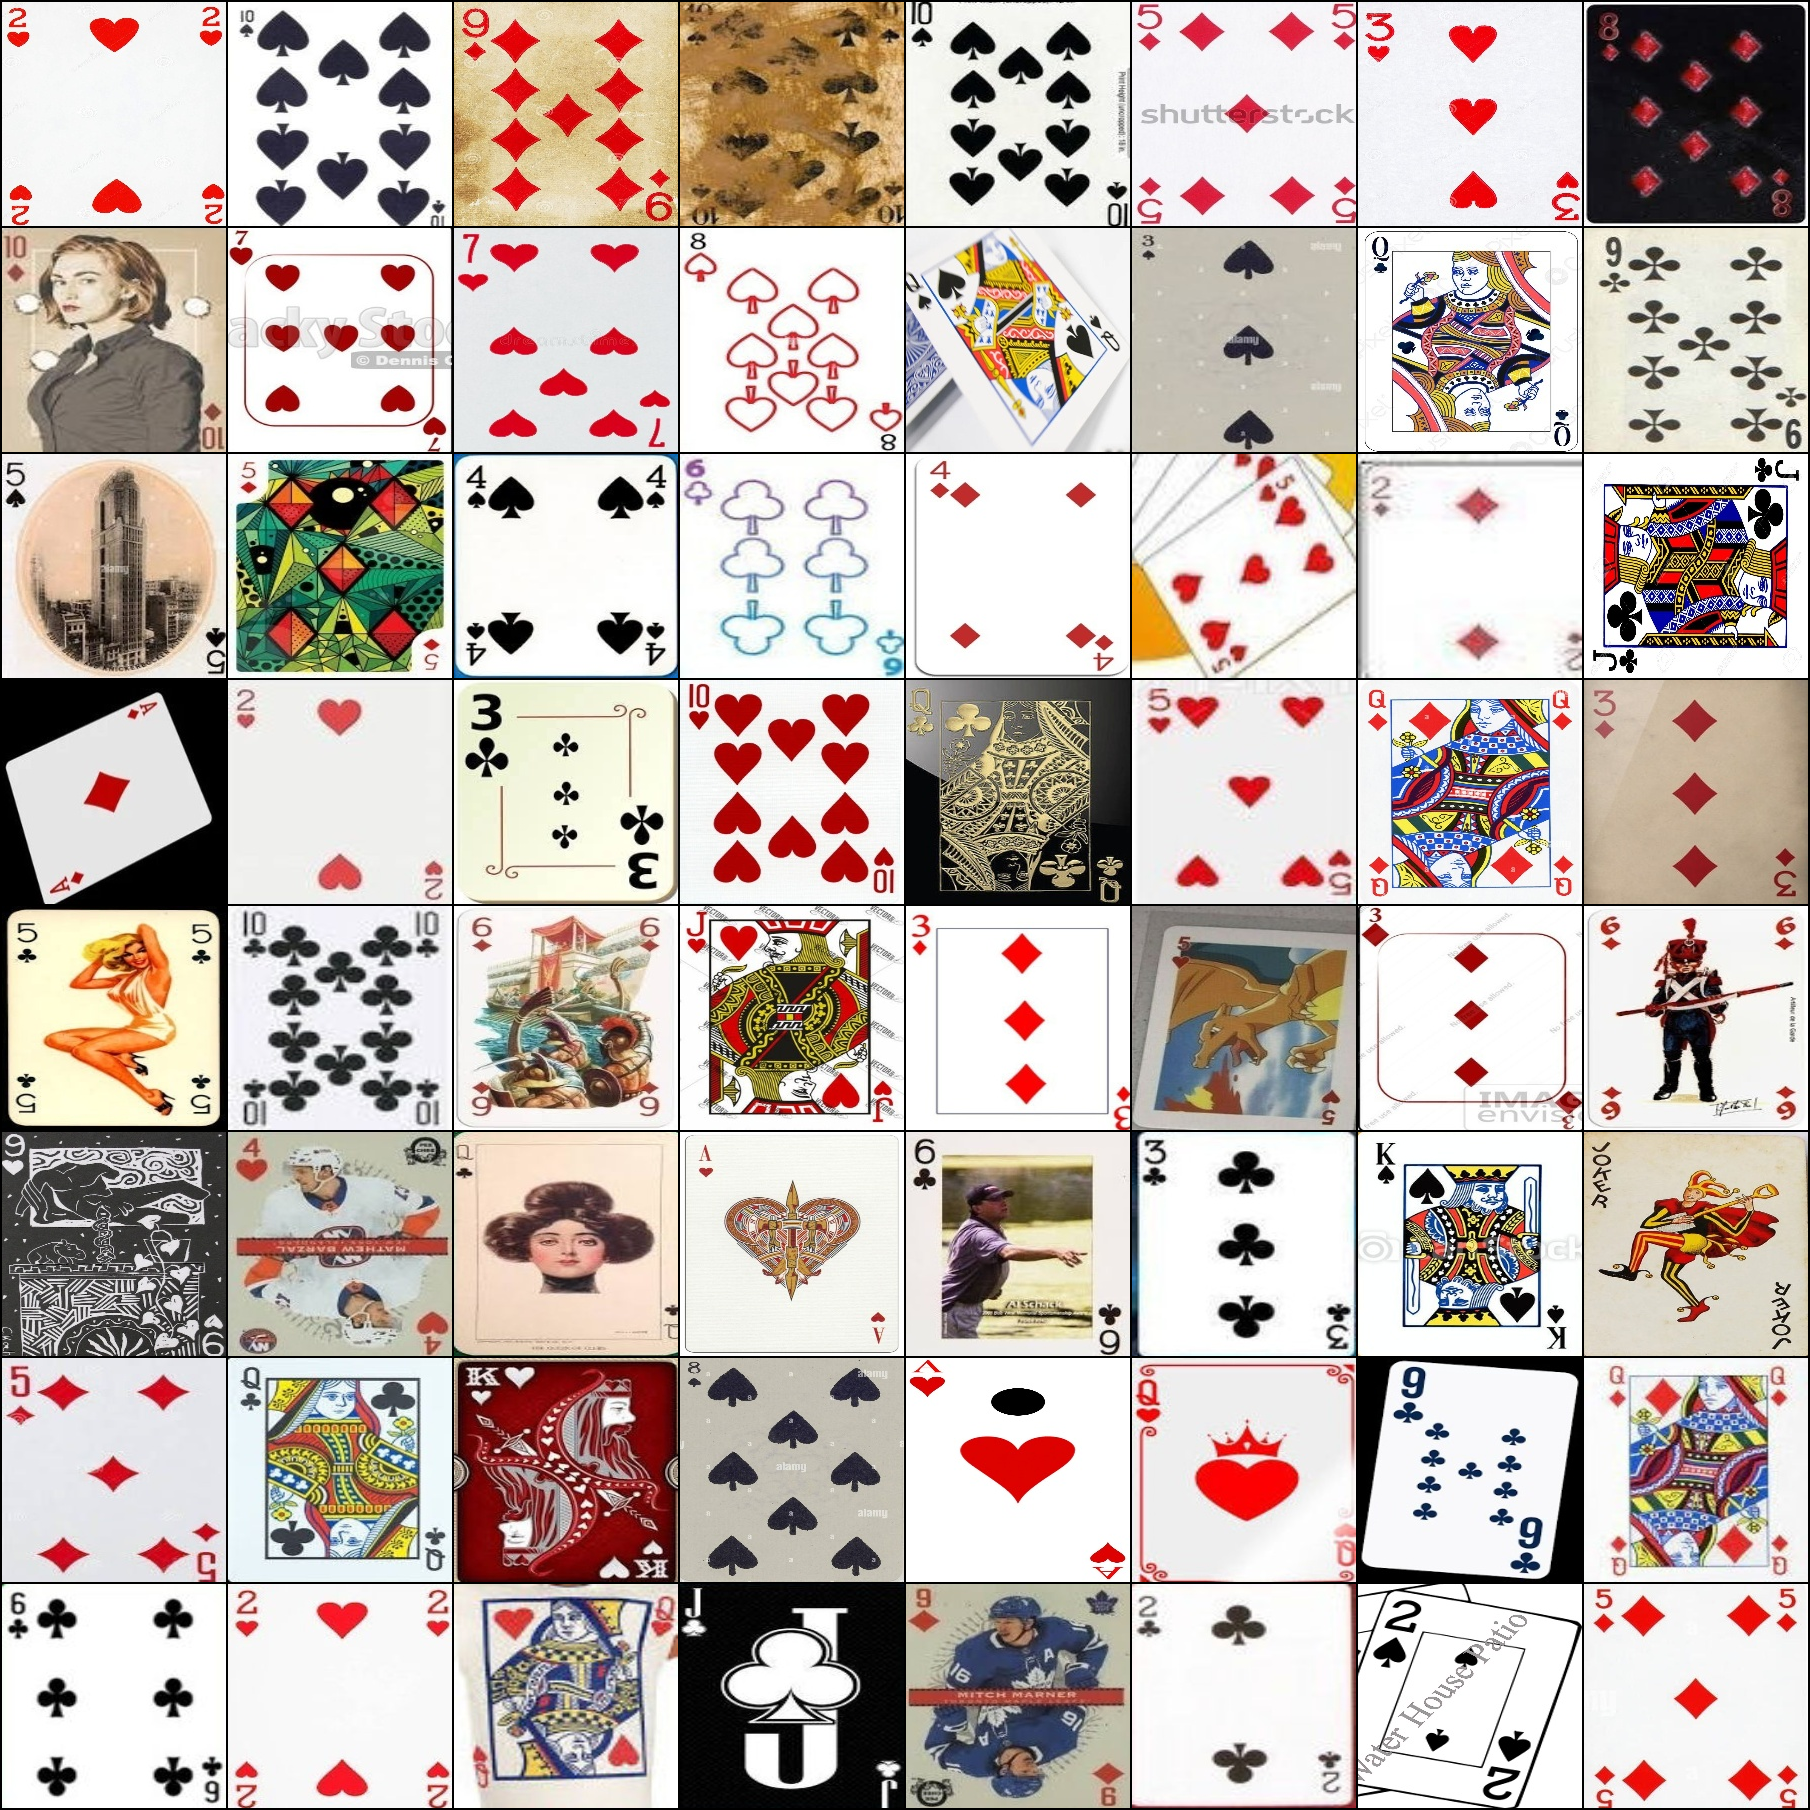

In [ ]:
# Fixed input for debugging
fixed_x, _ = next(iter(train_loader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class UnFlatten(nn.Module):
    def forward(self, input, size=36864):
        # Check if the input tensor has the expected shape
        if input.shape != (input.size(0), size, 1, 1):
            # Reshape the input tensor to the expected shape
            input = input.view(input.size(0), size, 1, 1)
        return input

In [ ]:
class VAE(nn.Module):
  def __init__(self, image_channels=3, h_dim=36864, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=7, stride=3),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=3),
            nn.Sigmoid(),
        )

  def reparameterize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
      # return torch.normal(mu, std)
      esp = torch.randn(*mu.size())
      z = mu + std * esp
      return z

  def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

  def encode(self, x):
      h = self.encoder(x)
      z, mu, logvar = self.bottleneck(h)
      return z, mu, logvar

  def decode(self, z):
      z = self.fc3(z)
      z = self.decoder(z)
      return z

  def forward(self, x):
      z, mu, logvar = self.encode(x)
      z = self.decode(z)
      return z, mu, logvar

In [ ]:
image_channels = fixed_x.size(1)

In [ ]:
vae = VAE(image_channels=image_channels).to(device)

In [ ]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [ ]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [ ]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(train_loader):
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1,
                                epochs, loss/batch_size, bce/batch_size, kld/batch_size)
        print(to_print)

torch.save(vae.state_dict(), 'vae.torch')

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/7] Loss: 107502.820 107502.820 0.000
Epoch[1/7] Loss: 106532.883 106532.867 0.019
Epoch[1/7] Loss: 283527.844 283527.125 0.712
Epoch[1/7] Loss: 104611.117 104611.070 0.044
Epoch[1/7] Loss: 107134.656 107134.648 0.008
Epoch[1/7] Loss: 106704.859 106704.859 0.002
Epoch[1/7] Loss: 106823.086 106823.086 0.001
Epoch[1/7] Loss: 106450.906 106450.906 0.000
Epoch[1/7] Loss: 106157.844 106157.844 0.000
Epoch[1/7] Loss: 105385.422 105385.422 0.000
Epoch[1/7] Loss: 104195.672 104195.672 0.000
Epoch[1/7] Loss: 104172.336 104172.336 0.001
Epoch[1/7] Loss: 102538.672 102538.672 0.001
Epoch[1/7] Loss: 101674.445 101674.445 0.001
Epoch[1/7] Loss: 100493.531 100493.531 0.001
Epoch[1/7] Loss: 98459.195 98459.195 0.001
Epoch[1/7] Loss: 94887.570 94887.570 0.002
Epoch[1/7] Loss: 102141.516 102141.508 0.005
Epoch[1/7] Loss: 95792.930 95792.930 0.002
Epoch[1/7] Loss: 96297.328 96297.328 0.002
Epoch[1/7] Loss: 95697.812 95697.812 0.002
Epoch[1/7] Loss: 93034.664 93034.664 0.002
Epoch[1/7] Loss: 92034

KeyboardInterrupt: 

In [ ]:
def compare(x,model):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

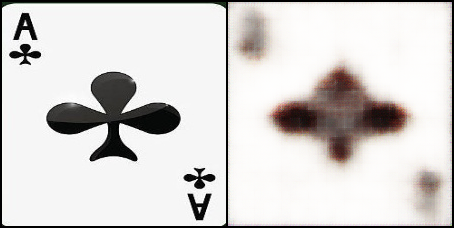

In [ ]:
fixed_x = trainset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x,vae)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

# GAN

In [10]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Random Seed:  999


In [48]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 224

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

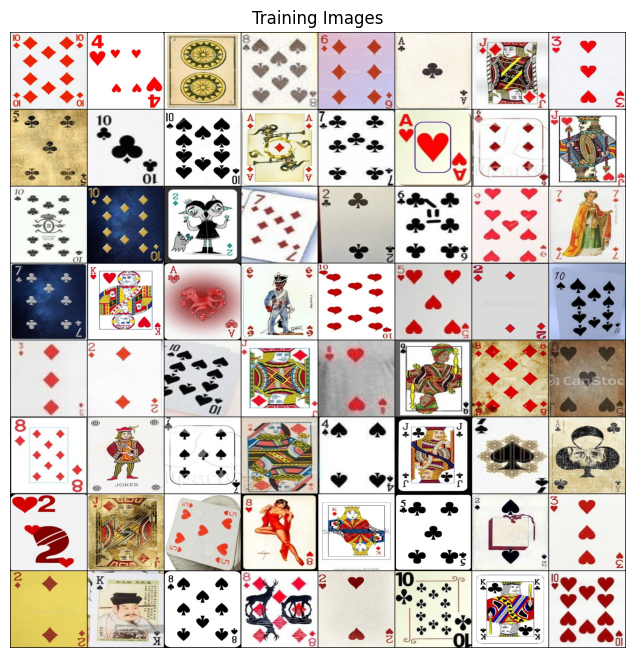

In [49]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
ganset = datasets.ImageFolder(root='train', transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                           ]))
gan_loader = torch.utils.data.DataLoader(ganset, batch_size=batch_size, shuffle=True)

# Plot some training images
real_batch = next(iter(gan_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [50]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [51]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
          # input is Z, going into a convolution
          nn.ConvTranspose2d(nz, ngf * 16, 7, 1, 0, bias=False),  # Increase kernel size
          nn.BatchNorm2d(ngf * 16),
          nn.ReLU(True),
          nn.ConvTranspose2d(ngf*16, ngf * 8, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 8),
          nn.ReLU(True),
          nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 4),
          nn.ReLU(True),
          nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 2),
          nn.ReLU(True),
          nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )


    def forward(self, input):
        return self.main(input)

In [52]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [53]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 16, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [54]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [55]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(gan_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(gan_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(gan_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()